In [1]:
%load_ext autoreload
%autoreload 2

# Postmodel Analysis

This notebook will guide the `triage` user through some useful rutines to compare individual models across `model_group_id`'s and also `model_group`s. This is an interactive process that combines huntches and some general ways to compare models. Before starting this process, is important to run `triage`'s _Audition_ component which will filter `model_group_id`'s using user-defined metrics (see [Audition](https://github.com/dssg/triage/blob/master/src/triage/component/audition/Audition_Tutorial.ipynb) to explore more). 

In [2]:
import pandas as pd
import numpy as np
from collections import OrderedDict
from utils.aux_funcs import create_pgconn, get_models_ids
from triage.component.catwalk.storage import ProjectStorage, ModelStorageEngine, MatrixStorageEngine
from parameters import PostmodelParameters
from model_evaluator import ModelEvaluator
from model_group_evaluator import ModelGroupEvaluator

## Parameters

Postmodel need a set of parameters to pass through some of its functions. This will allow the user to better analyize its models, This parameters can be readed from a `.yaml` file (a `postmodeling_parameters.yaml` example is included in this Notebook). If you want to set other parameters, you can pass them to the `.yaml` file, and the `PostmodelParameters` class, will create them. 

You can define de selected models by either defining a path to an `Audition` output, or by adding your own prefered models. 

This parameters include: 
 - `project_path`: Path to matrices and modes (normally under `triage/output`)
 - `audition_output_path`: Path to Audition output `.json` file. 
 - `model_group_id`: List with selected `ModelGroup` from `Audition`
 - `metric`: Selected metric string (i.e. `precision@`,`recall@`)
 - `thresholds`: Selected threshold list (i.e. `rank_abs[50, 100]`)
 - `baseline_query`:A SQL query that returns evaluation metrics for the baseline models
 - `n_features_plots`: Number of features to plot importances (int)
 - `max_depth_error_trees`: For residual DecisionTrees, number of splits (int)

Some aesthetic parameters

 - `figsize`: Plot size (tuple)
 - `fontsize`: Font size for plots (int)

In [3]:
params = PostmodelParameters('postmodeling_config.yaml')

These are the parameters stored in the `postmodeling_config.yaml`, and the notebook will use this to set parameters in other functions

In [4]:
params.__dict__

{'project_path': '../../../../../../triage_output/output/',
 'audition_output_path': 'results_model_group_ids.json',
 'model_group_id': [19, 43, 55],
 'thresholds': {'rank_pct': [10]},
 'baseline_query': "SELECT g.model_group_id,\n       m.model_id,\n       EXTRACT('YEAR' FROM m.evaluation_end_time) AS as_of_date_year,\n       m.metric,\n       m.parameter,\n       m.value,\n       m.num_labeled_examples,\n       m.num_labeled_above_threshold,\n       m.num_positive_labels\n FROM test_results.evaluations m\n LEFT JOIN model_metadata.models g\n USING(model_id)\n WHERE g.model_group_id IN (1, 2, 3)\n       AND metric = 'precision@'\n       AND parameter = '10.0_pct'\n",
 'max_depth_error_tree': 5,
 'n_features_plots': 10,
 'figsize': (12, 12),
 'fontsize': 20}

### Create SQL Engine

In [5]:
engine = create_pgconn('db_credentials.yaml')

## Model and Model Group Evaluators

This class will contain all the individual `model_id`'s (the part of the `model_group_id`) for each of the `model_group_id`'s defined in the paramters configuration file. To instantiate all the models we can create a list with each of the models of interest


In [6]:
# List individual models
list_tuple_models = get_models_ids(params.model_group_id, engine)
l_t = [ModelEvaluator(i.model_group_id, i.model_id, engine) for i in list_tuple_models]

# Model group object (useful to compare across model_groups and models in time)
audited_models_class = ModelGroupEvaluator(tuple(params.model_group_id), engine)

We can explore the contents of the `ModelEvaluator` for each `model_id` inside the specified `model_group_id`.

In [7]:
print(l_t[0])

{'model_id': 44, 'model_group': 19, 'model_type': 'sklearn.ensemble.RandomForestClassifier', 'as_of_date': 'January 13, 2016', 'model_hyperparameters': {'criterion': 'gini', 'class_weight': 'balanced', 'max_features': 'sqrt', 'n_estimators': 1000, 'min_samples_leaf': 1, 'min_samples_split': 50}}


In [8]:
audited_models_class.metadata

[{'model_id': 152,
  'model_group_id': 43,
  'model_hash': '2dad45255e8e6ab538f96ead00c40e5c',
  'hyperparameters': {'criterion': 'gini',
   'class_weight': 'balanced',
   'max_features': 'sqrt',
   'n_estimators': 1000,
   'min_samples_leaf': 1,
   'min_samples_split': 50},
  'train_end_time': datetime.datetime(2018, 1, 13, 0, 0),
  'train_matrix_uuid': '4b09c67e31e6a0cba9f99aef600967c2',
  'training_label_timespan': datetime.timedelta(30),
  'model_type': 'sklearn.ensemble.RandomForestClassifier',
  'model_config': {'state': 'active',
   'label_name': 'inspected',
   'cohort_name': 'active_facilities',
   'feature_groups': ['prefix: results', 'prefix: risks'],
   'label_timespan': '1month',
   'as_of_date_frequency': '1month',
   'max_training_history': '5y'},
  'test_matrix_uuid': '3a1535f25b08cfe3749af36f8e7235bd'},
 {'model_id': 80,
  'model_group_id': 55,
  'model_hash': '6d51a3c823df44e2b3f08bcbffc383e3',
  'hyperparameters': {'criterion': 'gini',
   'class_weight': 'balanced',


## Let's talk about postmodeling:

### How the scores looks like?

One of the main metrics we want to evaluate from each of our models is their predictions. The way `triage` modeling component works pivot around `model_groups_id` as the main element of modeling. Model Groups have the same model configuration (hyperparameters, feature space, etc) with different models ran in different prediction windows. 

We want to check a few things when exploring score predictions: 

1. Score distributions
2. Score distributions by trained label

Audition will output a dict object with a set of models for each of the defined metrics. We can either read from Audition output, or we can define a list (`audited_models`) to start the post-modeling exploration. We will get each individual `model_id` from the audited `model_groups_id`'s and get the relevant metadata and matrices for each models using the `Model` class. 

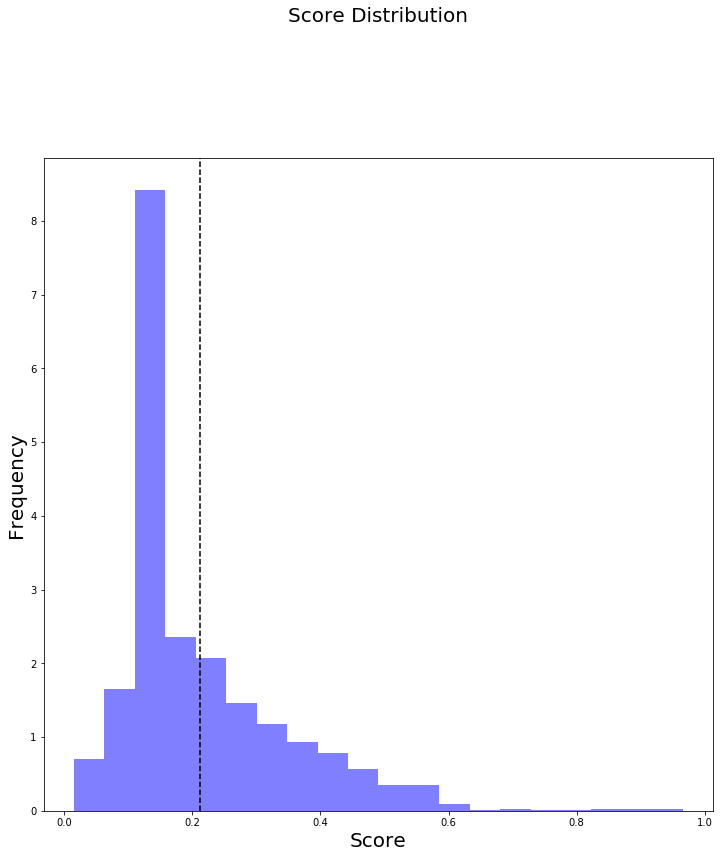

In [9]:
l_t[0].plot_score_distribution(figsize=params.figsize)

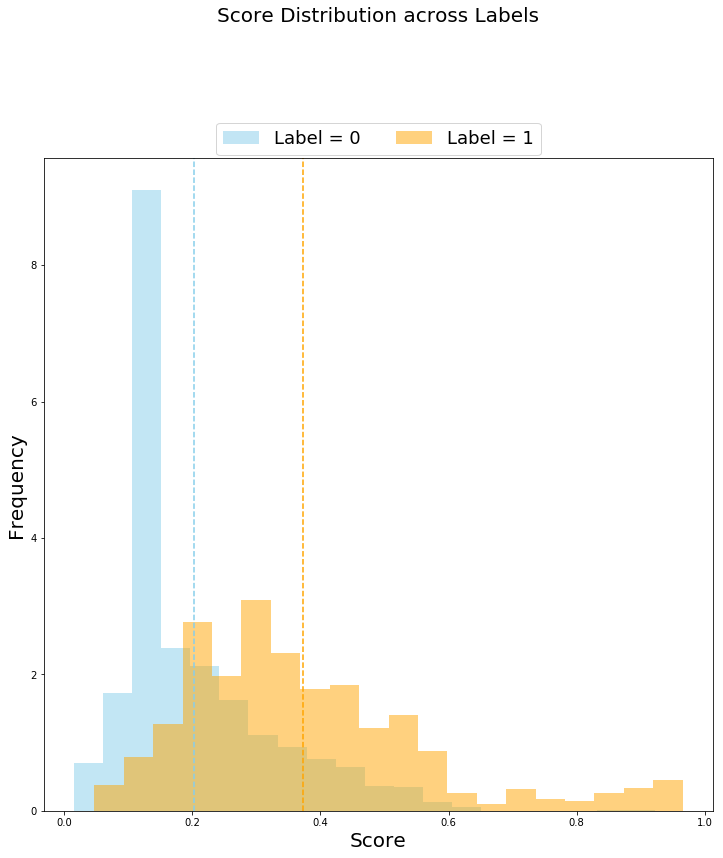

In [10]:
l_t[0].plot_score_label_distributions(figsize=params.figsize)

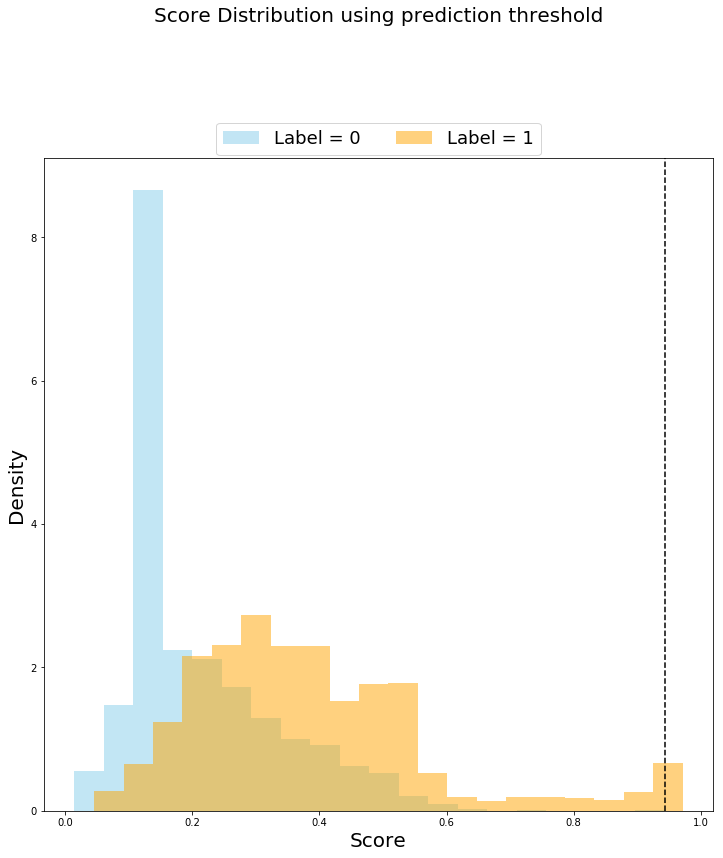

In [12]:
l_t[1].plot_score_distribution_thresh(figsize=params.figsize, param_type = 'rank_abs', param = 25)

### How's the precision across time for each of my selected model groups?

But, how accurate are these scores? In the paramteres configuration fil we defined a set (or probably one) threshold that will help us to classify (label) predicted entities as 1's or O's. These will help us to assess each of the model groups across time. To have better insights about our model quality, we can compare our model groups against a baseline model (also defined in our configuration file). 

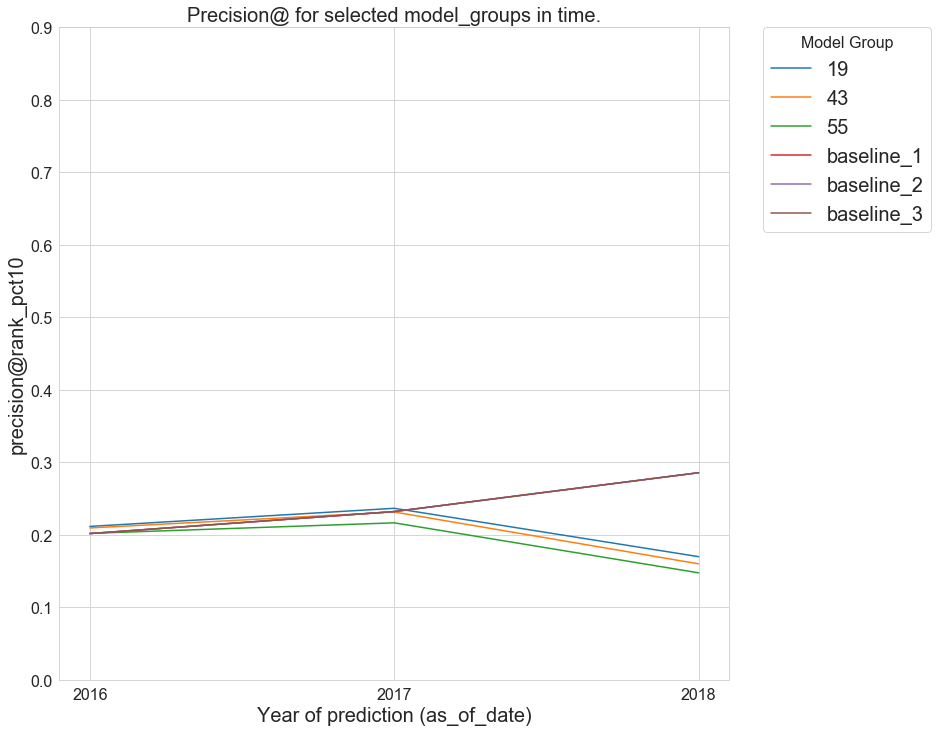

In [11]:
a = audited_models_class.plot_prec_across_time(param_type='rank_pct',
                                           param=10,
                                           baseline=True,
                                           baseline_query=params.baseline_query,
                                           metric='precision@',
                                           figsize=params.figsize)

### Features: what's is happening behind this prediction?

We can extract individual feature importances from `triage` results schema and indentify the important features for each model. In this `dirtyduck` example, we find that a significant set of features are correlated, usually corresponding to imputated values, or `NULL` values in their categorization. 

### How are the model features correlated (and its feature groups)?

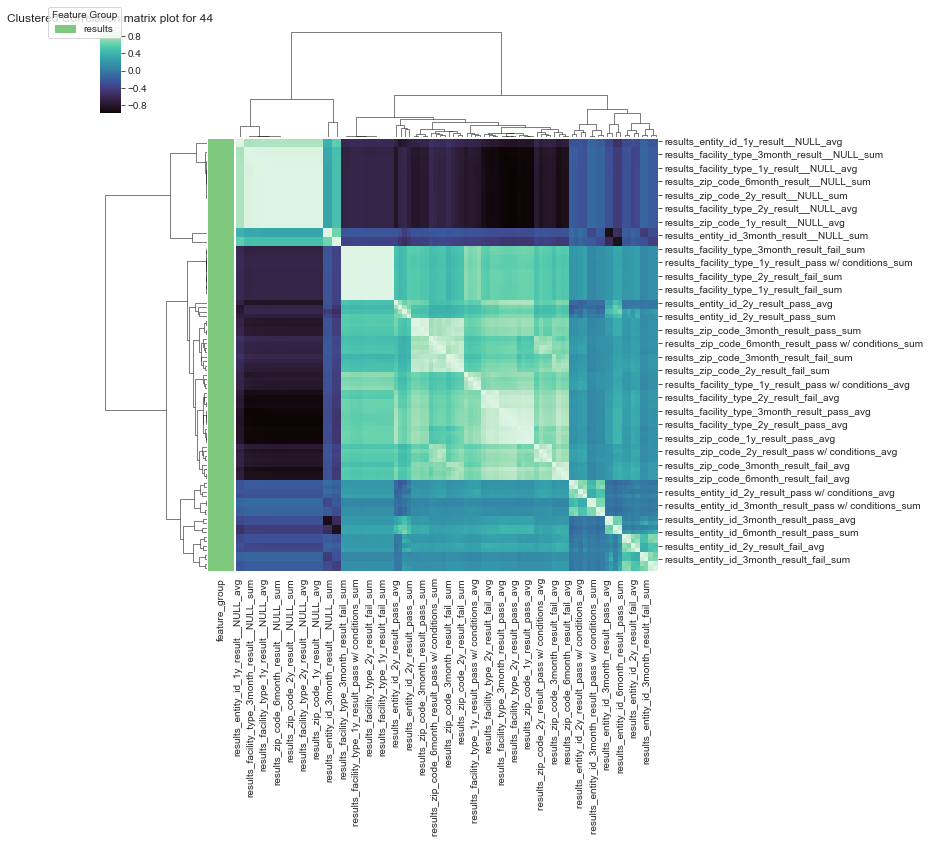

In [15]:
l_t[0].cluster_correlation_features(path=params.project_path,
                                    feature_group_subset_list = ['results']) 

### How many zeroes/imputation our model feature space has?

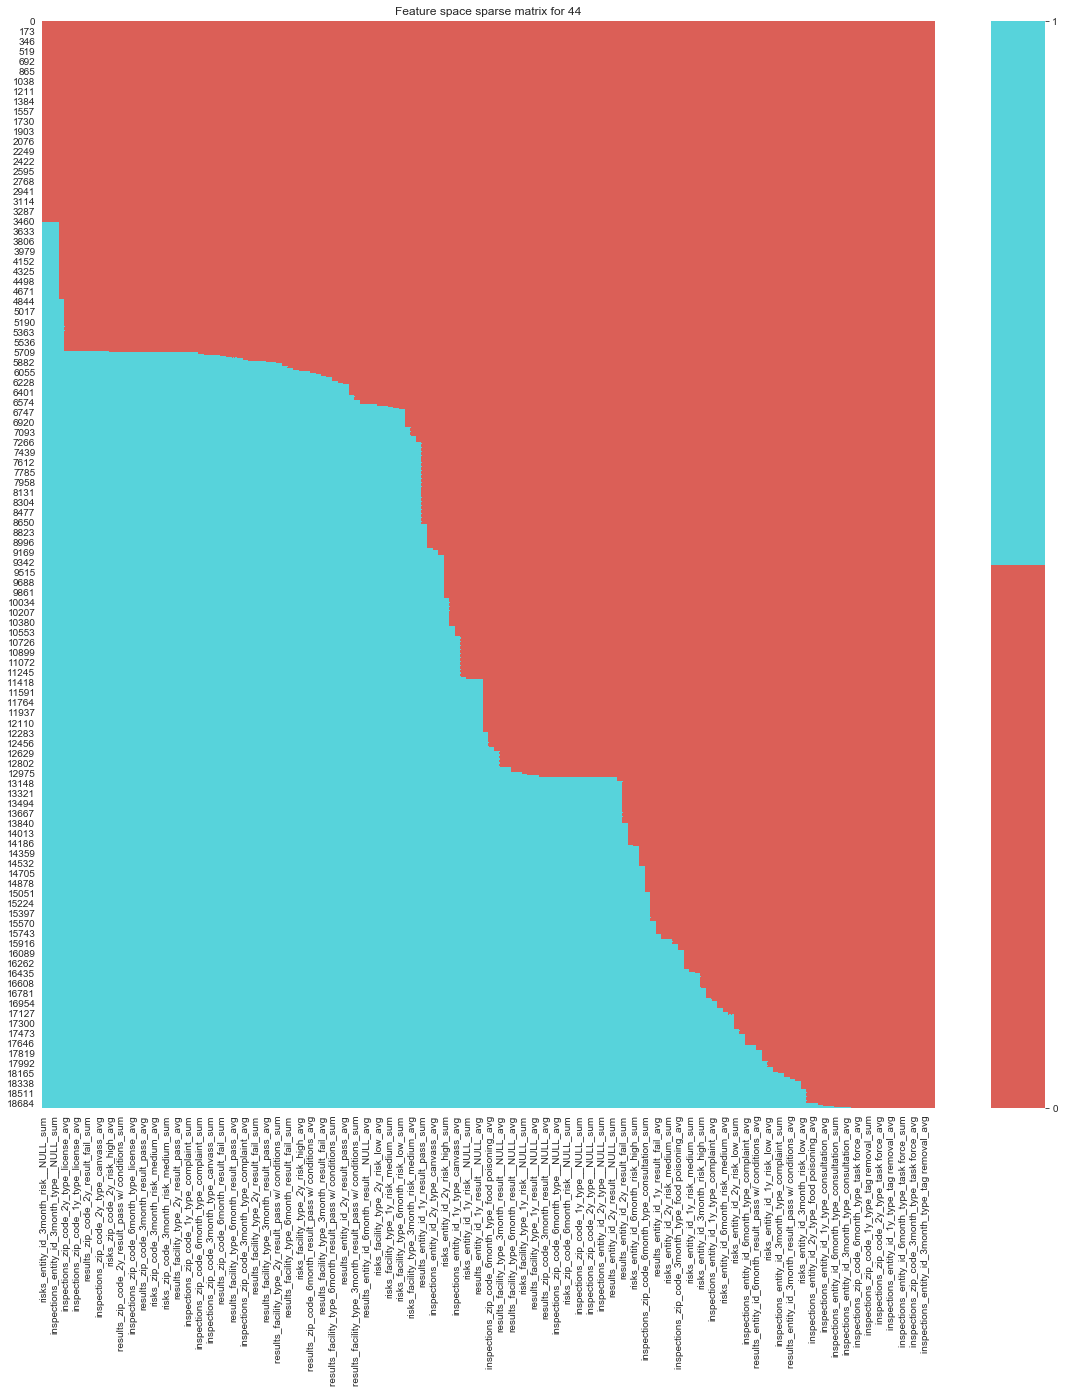

In [16]:
l_t[0].cluster_correlation_sparsity(path=params.project_path)

### Which is the feature that has the biggest relevance in my prediction?

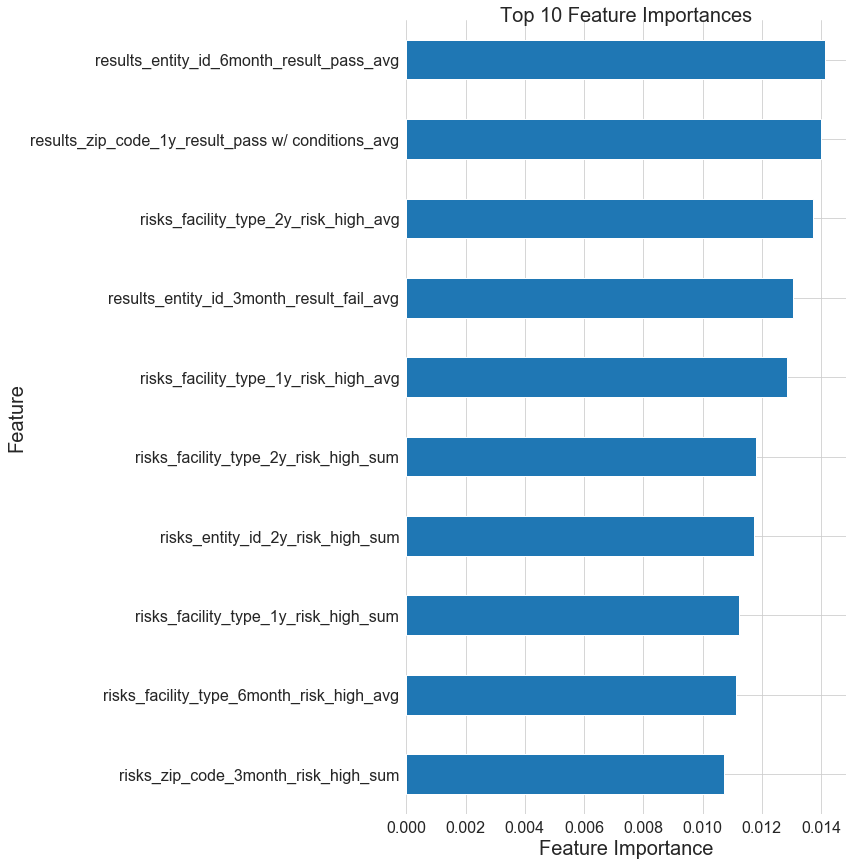

In [12]:
l_t[0].plot_feature_importances(n_features_plots=params.n_features_plots, figsize=params.figsize)

### _Another way of exploring this relationship:_

/Users/ivan/.pyenv/versions/triage-3.6.2/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/ivan/.pyenv/versions/triage-3.6.2/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.19.1 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


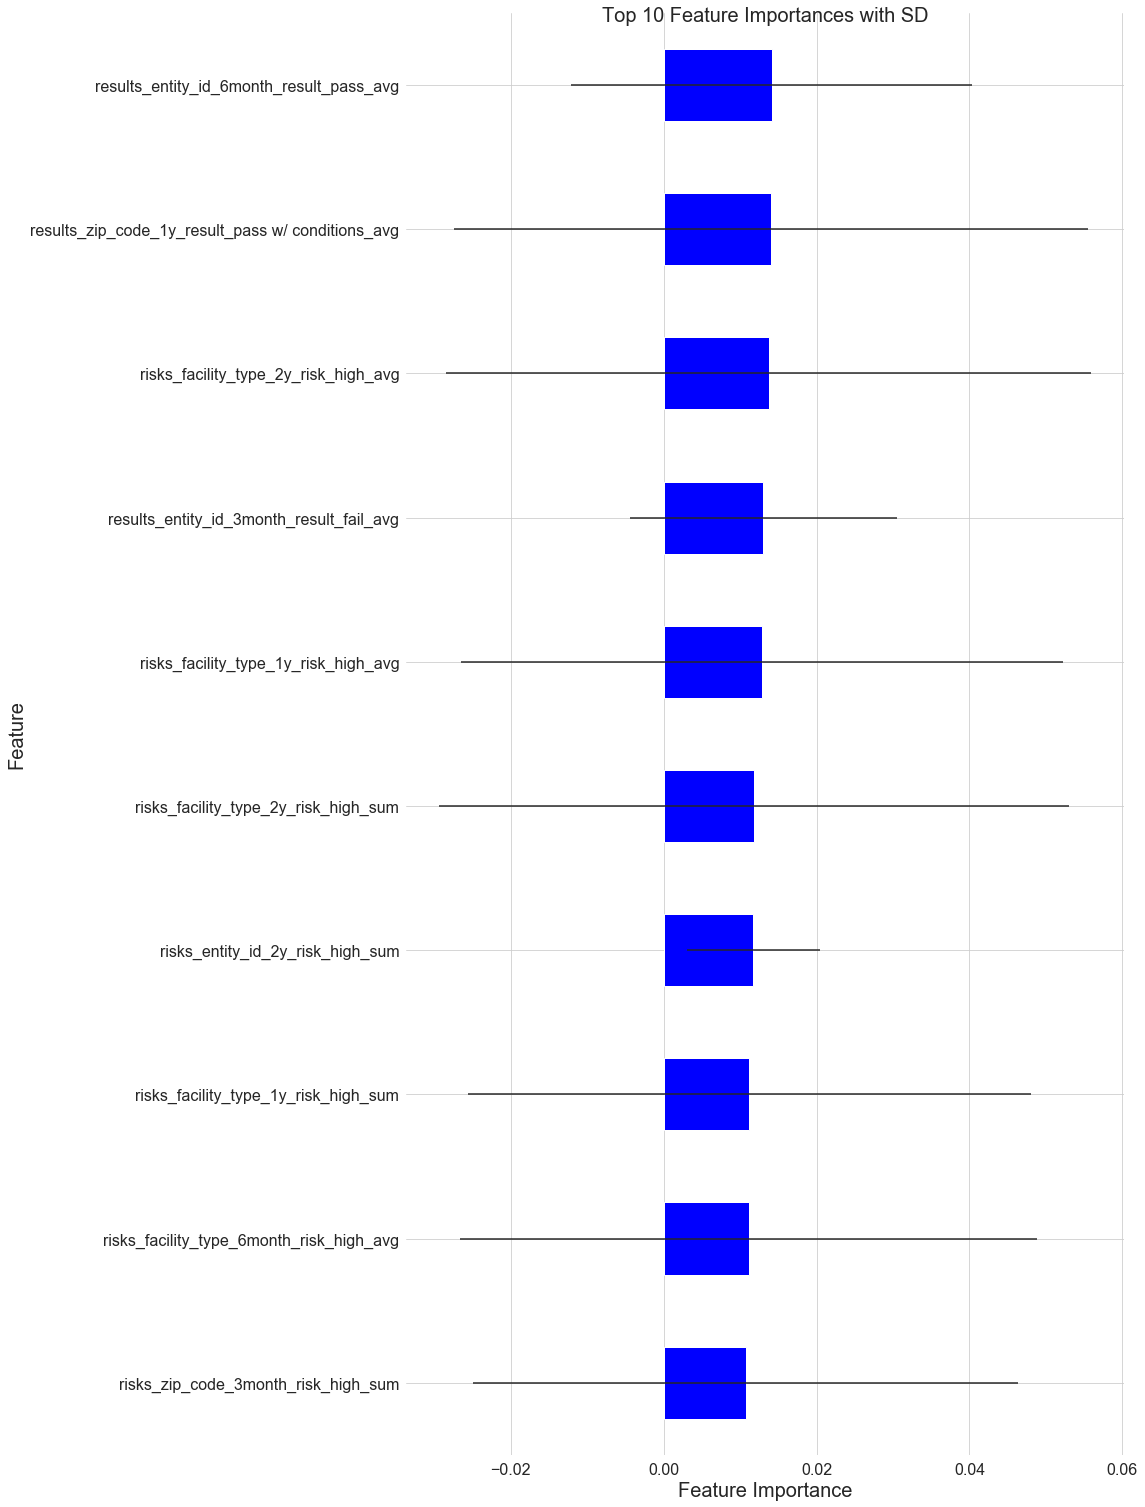

In [18]:
l_t[0].plot_feature_importances_std_err(path= params.project_path, 
                                        n_features_plots = params.n_features_plots)

/Users/ivan/.pyenv/versions/triage-3.6.2/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 0.19.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/Users/ivan/.pyenv/versions/triage-3.6.2/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator RandomForestClassifier from version 0.19.1 when using version 0.19.2. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


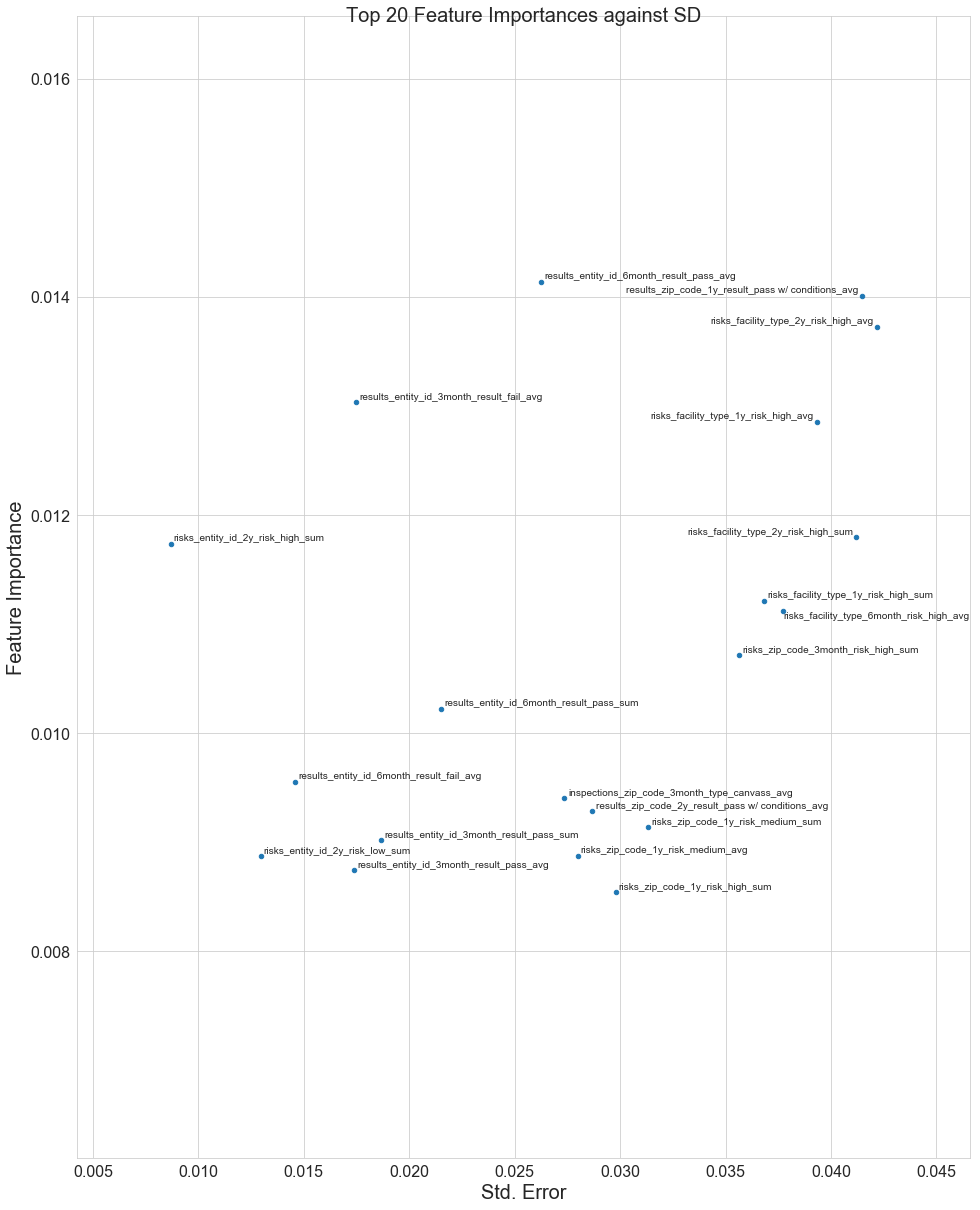

In [155]:
l_t[0].plot_feature_importances_std_err(path= params.project_path, 
                                        n_features_plots = 20,
                                        bar=False)

### Which feature group has more relevance in my model performance? 

Feature inclusion and exclusion (LOI and LOO) performance allow us to compare different experiments made in each `model_group_id` and see how the exclusion or inclusion of new feature groups have a leverage in the user defined metric to assess performance. The method `feature_groups` depicts the expriment type for each of the models. 

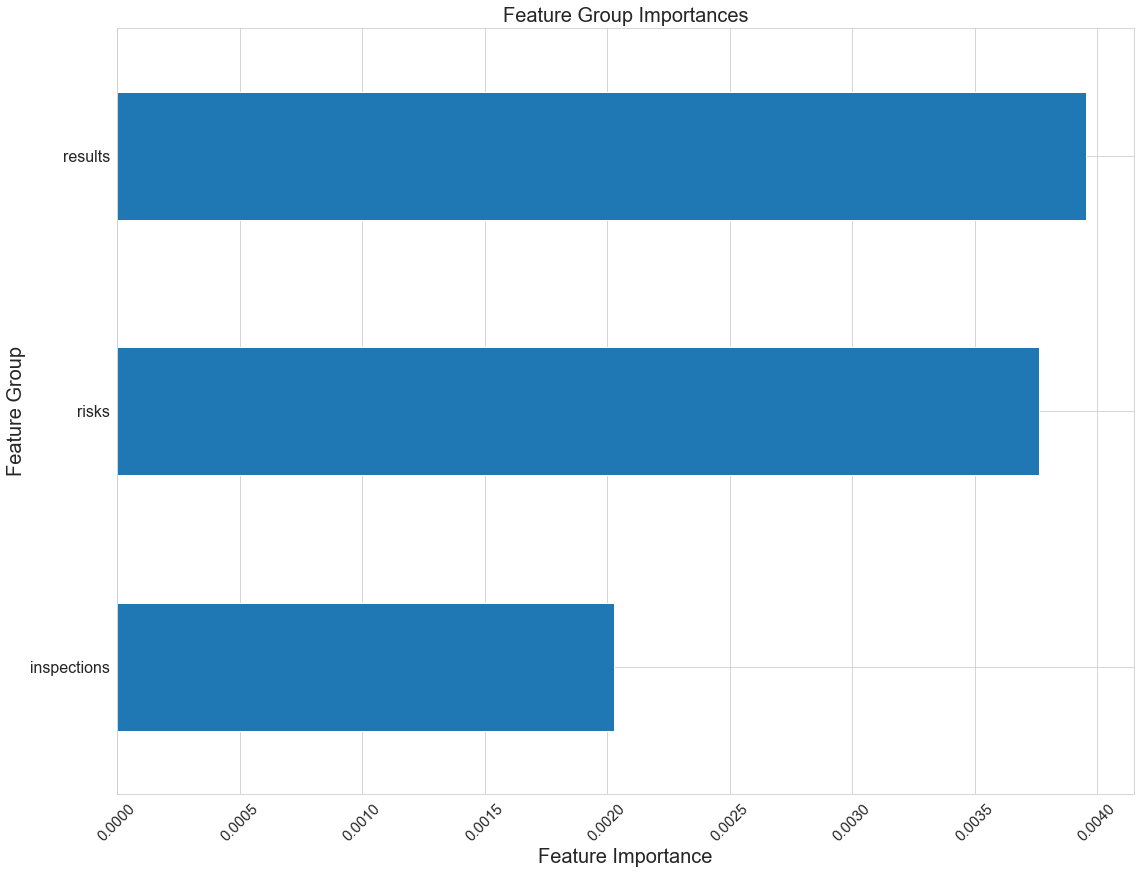

In [14]:
l_t[0].plot_feature_group_average_importances()

In a more detailed way, we can explore features and their distribution across label values

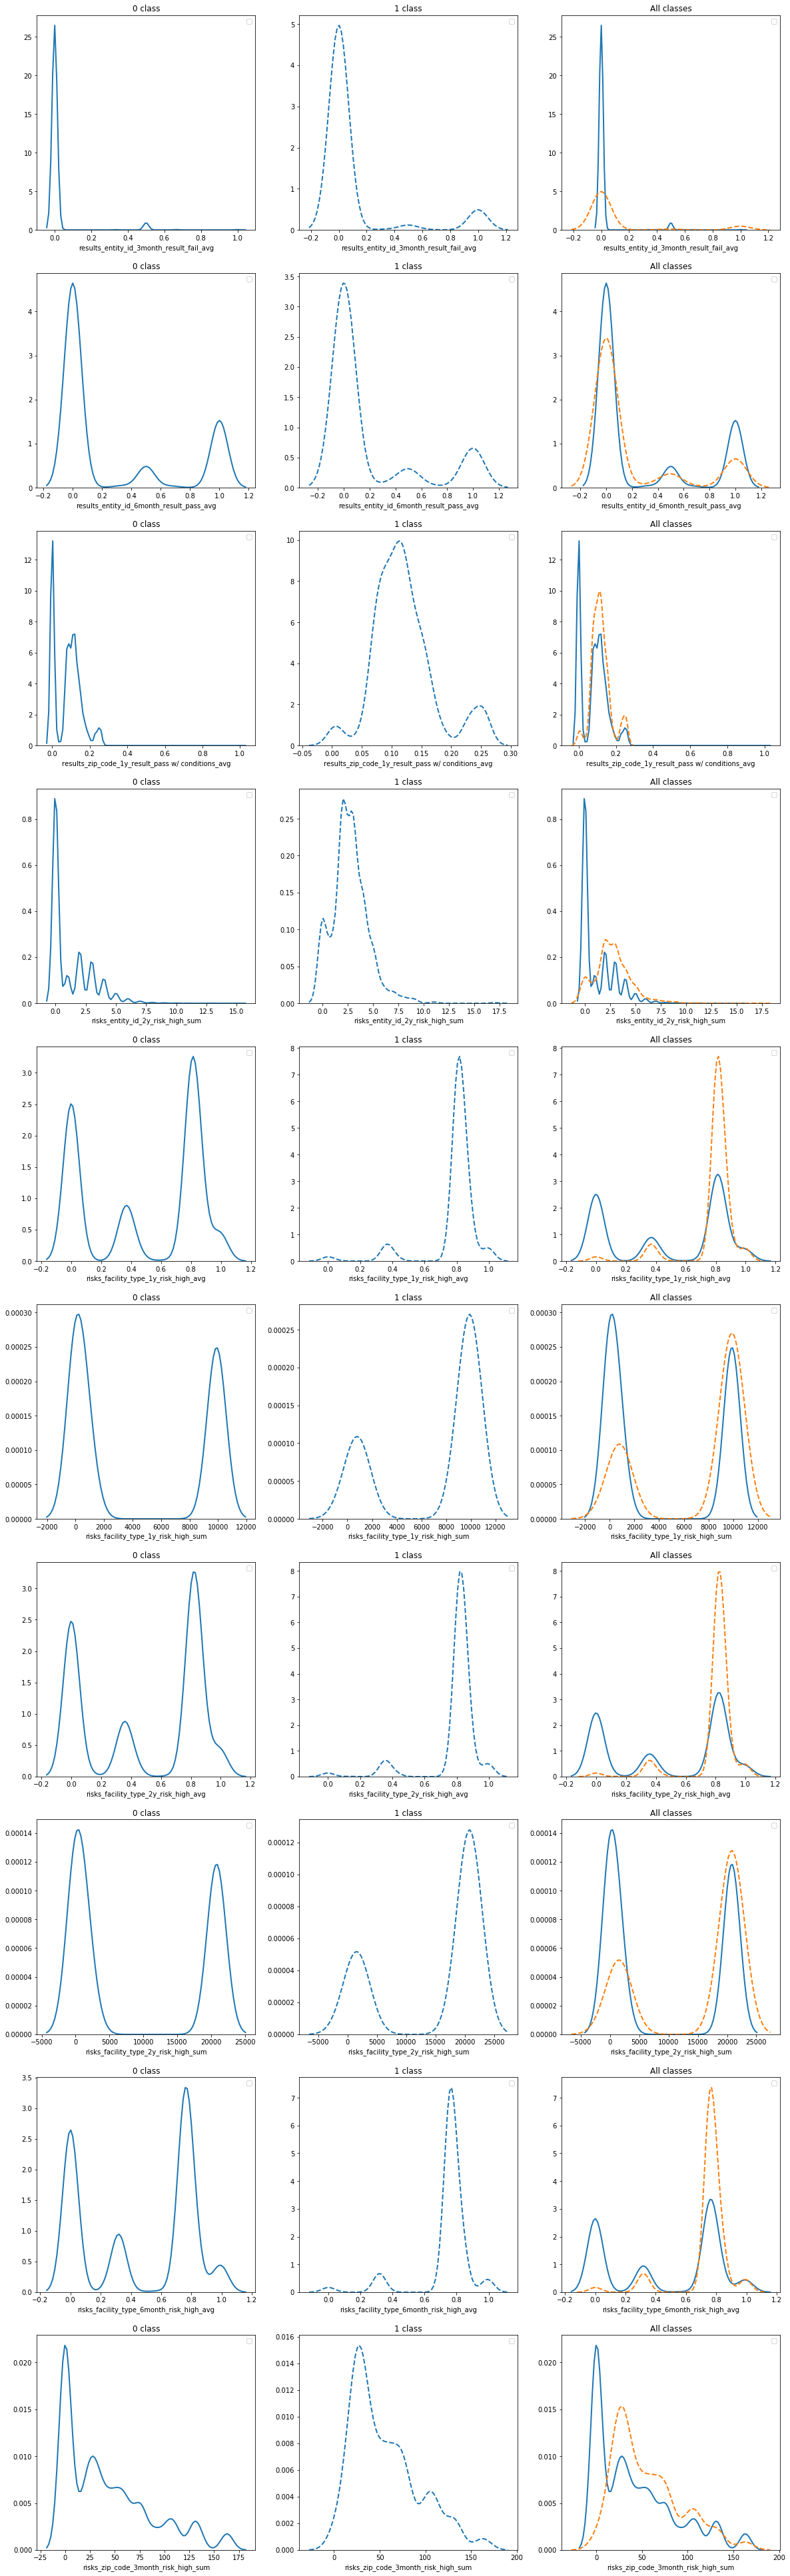

In [15]:
l_t[0].plot_feature_distribution(path=params.project_path)

/Users/ivan/triage/src/triage/component/postmodeling/contrast/model_group_evaluator.py:459: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  else row['feature_group_array'] + '_loi', axis=1)


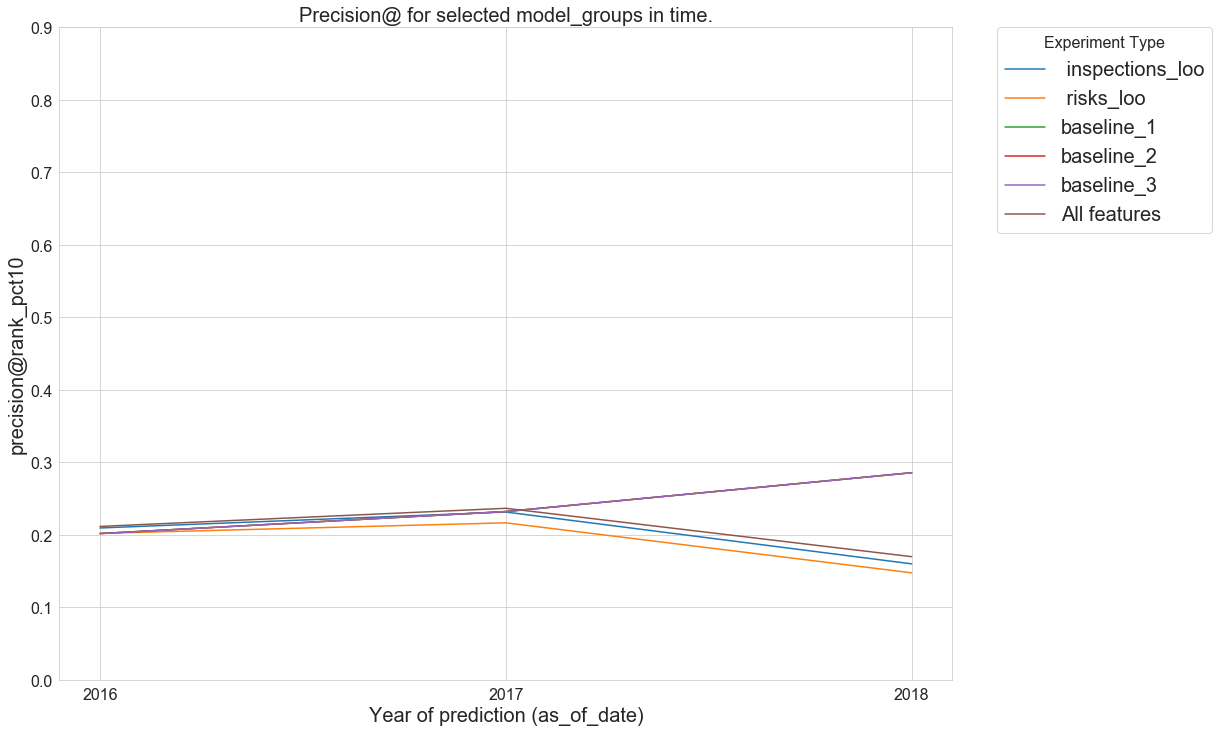

In [15]:
audited_models_class.feature_loi_loo(param_type='rank_pct',
                                     param=10,
                                     metric='precision@',
                                     baseline=True,
                                     baseline_query=params.baseline_query)

### Crosstabs: once predicted, what are the main difference between my groups? What's the feature that characterise my predictions? 

Crosstabs is already on development, you can [check out it](https://github.com/dssg/postmodel-analysis/tree/sqlqueries/postmodel/crosstabs). `crosstabs` will generate a table with the differences in feature distributions across predicted entites using a top-k precision. 

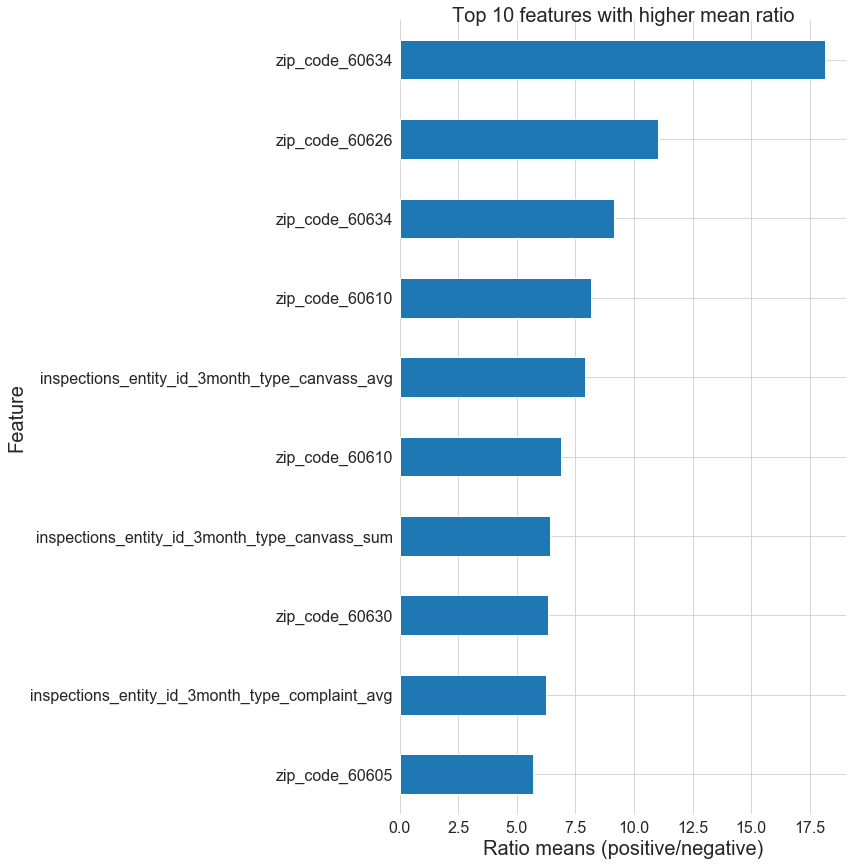

In [16]:
l_t[0].crosstabs_ratio_plot(n_features=params.n_features_plots, 
                            figsize=params.figsize)

### What about the model metrics? 

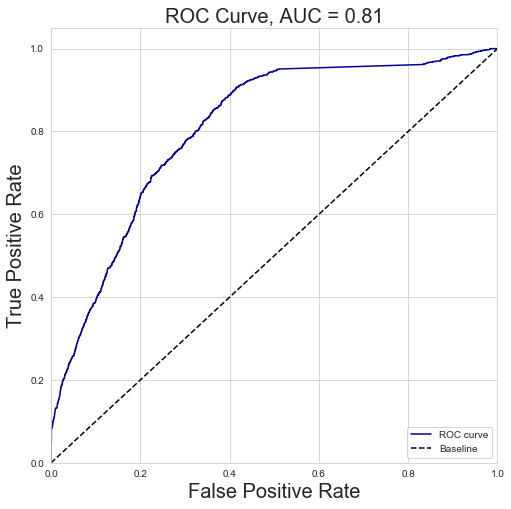

In [17]:
l_t[0].plot_ROC(figsize=(8,8))

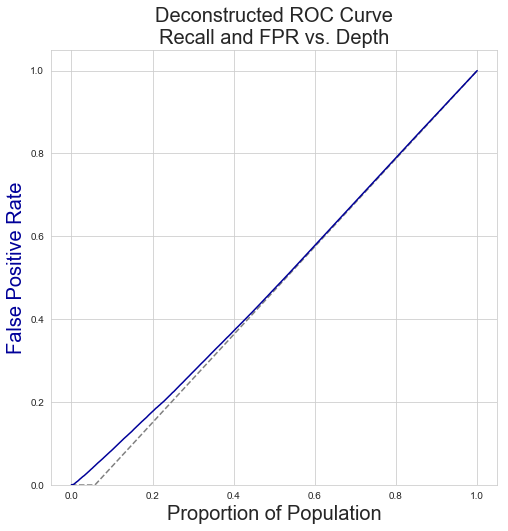

In [18]:
l_t[0].plot_recall_fpr_n(figsize=(8,8))

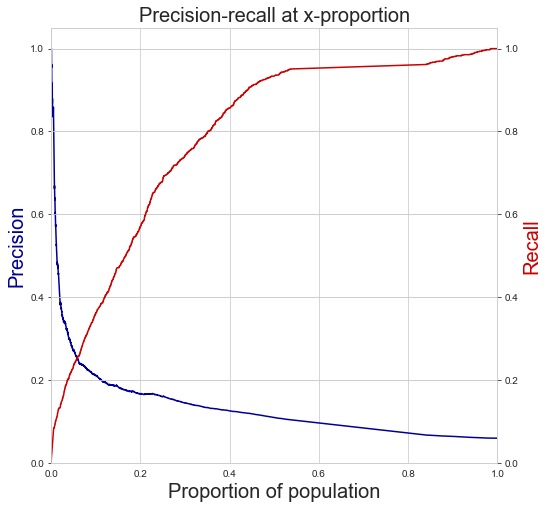

In [19]:
l_t[0].plot_precision_recall_n(figsize=(8,8))

### Our model make mistakes, why? 

We can explore which features of our space, or at which values, are some features generating errors in the model. This function `error_analysis` runs a Decision Tree for each model based in one (or several) thresholds passed to the Postmodeling configuration file. The function will return the tree plot (saved as pdf under the `/error_analysis`). 

The function will make *four* comparisons:
 - False Postives (1) vs. Rest of entities classified (0)
 - False Negatives (1) vs. Rest of entities classified (0)
 - False Positives (1) vs. True Negatives (0)
 - False Negatives (1) vs. True Positives (0)
 
This set of analysis will serve to understand why some classification errors arise, and give some hints on how our model is performing. 

In [7]:
l_t[0].error_analysis(params.thresholds_iterator,
                      depth=params.max_depth_error_tree,
                      path=params.project_path,
                      view_plots=False)

rank_abs 10
error_analysis_FPRvsAll_44_rank_abs@10.gv
error_analysis_FNRvsAll_44_rank_abs@10.gv
error_analysis_FNRvsTP_44_rank_abs@10.gv
error_analysis_FPRvsTN_44_rank_abs@10.gv
rank_abs 20
error_analysis_FPRvsAll_44_rank_abs@20.gv
error_analysis_FNRvsAll_44_rank_abs@20.gv
error_analysis_FNRvsTP_44_rank_abs@20.gv
error_analysis_FPRvsTN_44_rank_abs@20.gv
rank_abs 50
error_analysis_FPRvsAll_44_rank_abs@50.gv
error_analysis_FNRvsAll_44_rank_abs@50.gv
error_analysis_FNRvsTP_44_rank_abs@50.gv
error_analysis_FPRvsTN_44_rank_abs@50.gv
rank_pct 10
error_analysis_FPRvsAll_44_rank_pct@10.gv
error_analysis_FNRvsAll_44_rank_pct@10.gv
error_analysis_FNRvsTP_44_rank_pct@10.gv
error_analysis_FPRvsTN_44_rank_pct@10.gv
rank_pct 20
error_analysis_FPRvsAll_44_rank_pct@20.gv
error_analysis_FNRvsAll_44_rank_pct@20.gv
error_analysis_FNRvsTP_44_rank_pct@20.gv
error_analysis_FPRvsTN_44_rank_pct@20.gv
rank_pct 50
error_analysis_FPRvsAll_44_rank_pct@50.gv
error_analysis_FNRvsAll_44_rank_pct@50.gv
error_analysis

Since each `model_id` has different temporal configurations, we can explore the prediction window for each of the models and identify the models that have the same temporal configuration. 

### Let's talk about model consistency

We can compare `model_groups_id` overall by looking at how consistent they are in flagging the same individuals. We checked the temporal consistency inside each `model_group_id` in the precision/recall time line in the first part of this Notebook, but we can also compare `model_group_id`'s by the composition of both the predicted individuals in one especific time window, and its features. Here we present two ways of doing these using a Jaccard Similarity Index, and a Ranked Correlation.  


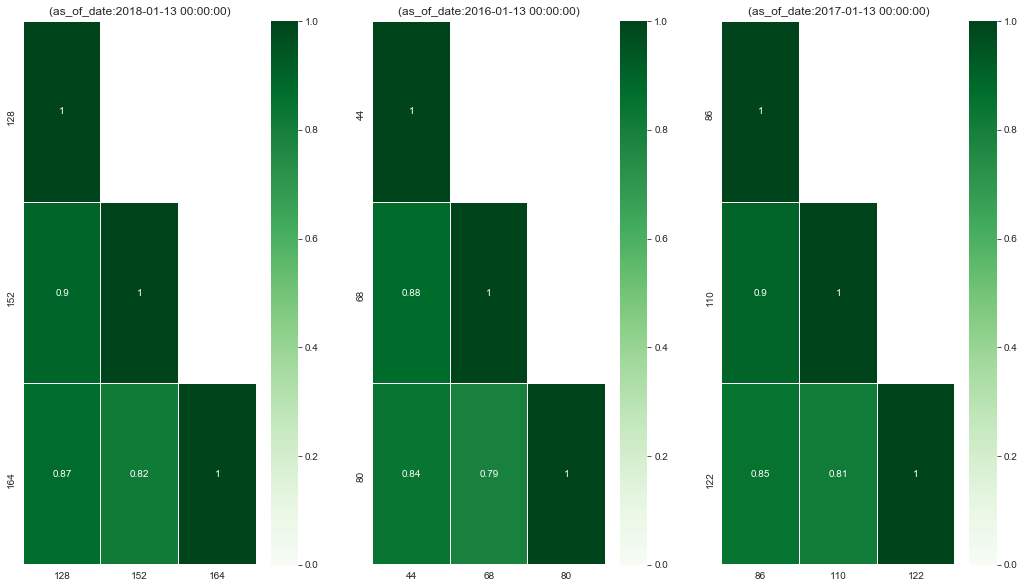

In [21]:
audited_models_class.plot_jaccard(param_type='rank_pct',
                                  param=50,
                                  temporal_comparison=True)

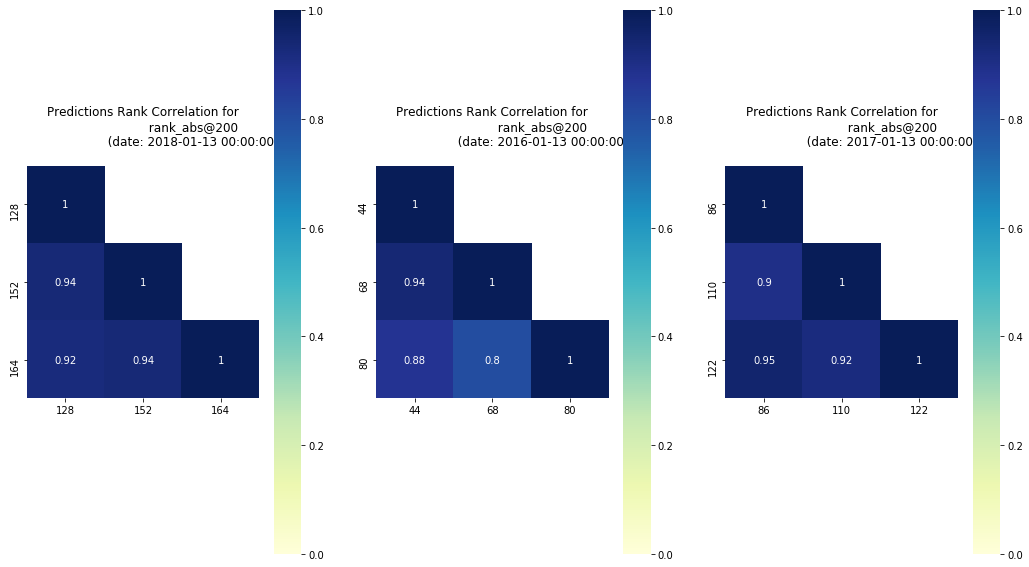

In [16]:
audited_models_class.plot_ranked_corrlelation_preds(param_type='rank_abs',
                                                    param=200,
                                                    temporal_comparison=True)

Although, we can compare the selection of each model for each predicted `as_of_date` using the overall

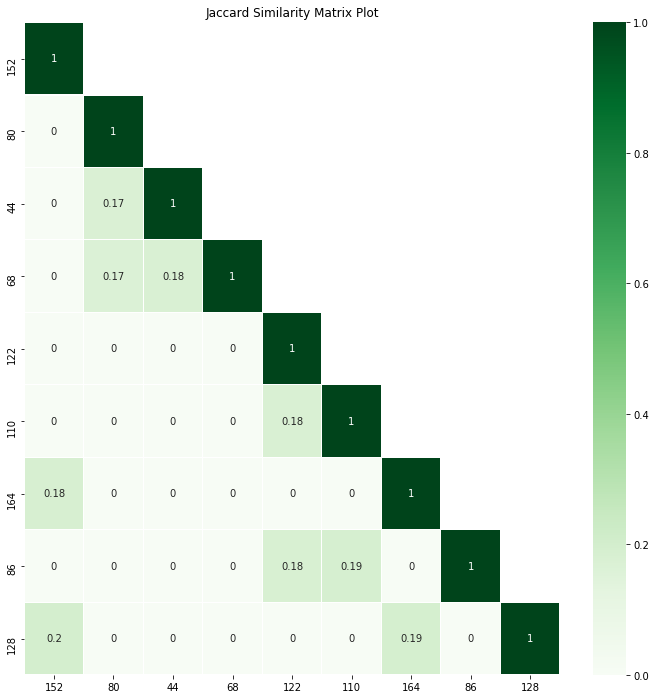

In [15]:
audited_models_class.plot_jaccard(param_type='rank_pct', 
                                  param=50,
                                  figsize=params.figsize)

Consistency also is desireable in the most relevant features for each of the models. We can explore this by exploring the correlation/overlap of ranked features across models

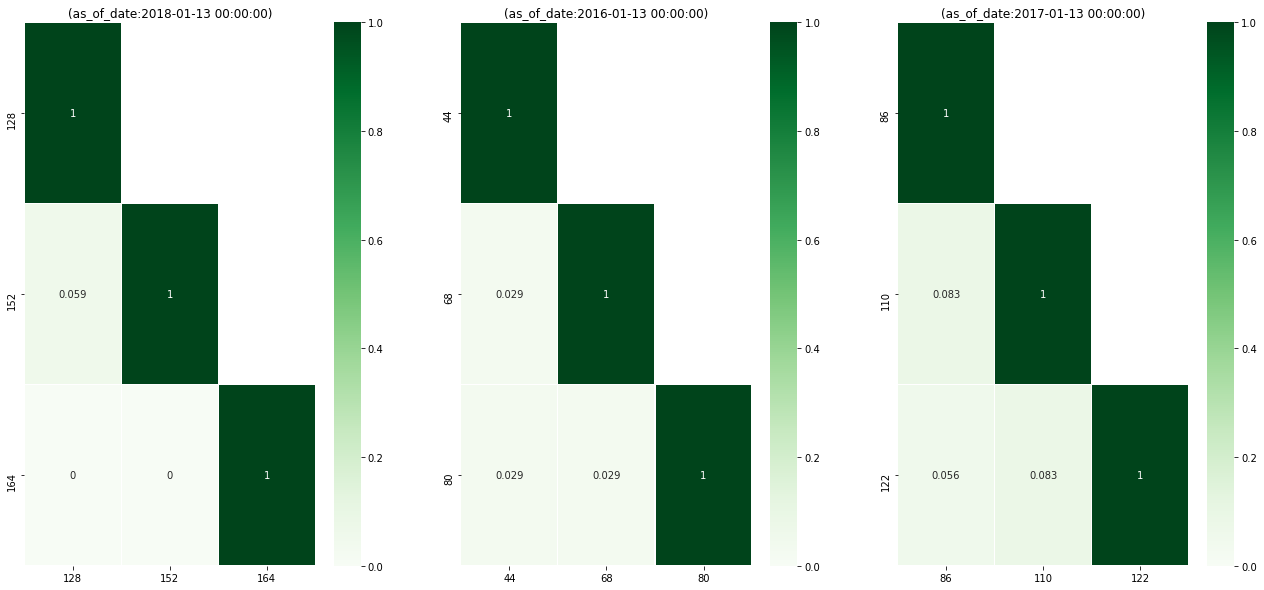

In [14]:
audited_models_class.plot_jaccard_features(top_n_features=20,
                                          temporal_comparison=True)

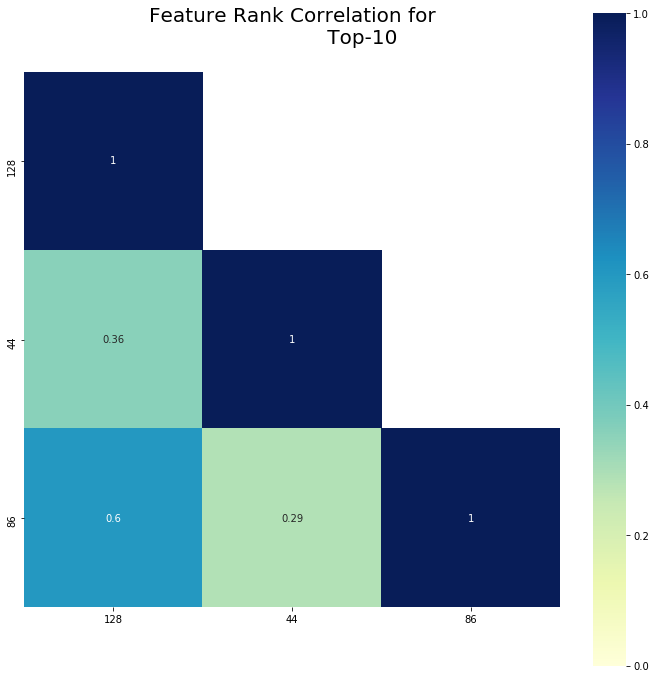

In [17]:
audited_models_class.plot_ranked_correlation_features(figsize=params.figsize,
                                                      top_n_features=params.n_features_plots)

### Model _"advanced"_ comparison

More than the mere overlap of ranked observations, we can think our comparisons from the distributions of our top observations. Not only we can visualize the distribution overlap, but also the ranking of the predicted entities in their percentiles

/Users/ivan/.pyenv/versions/triage-3.6.2/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


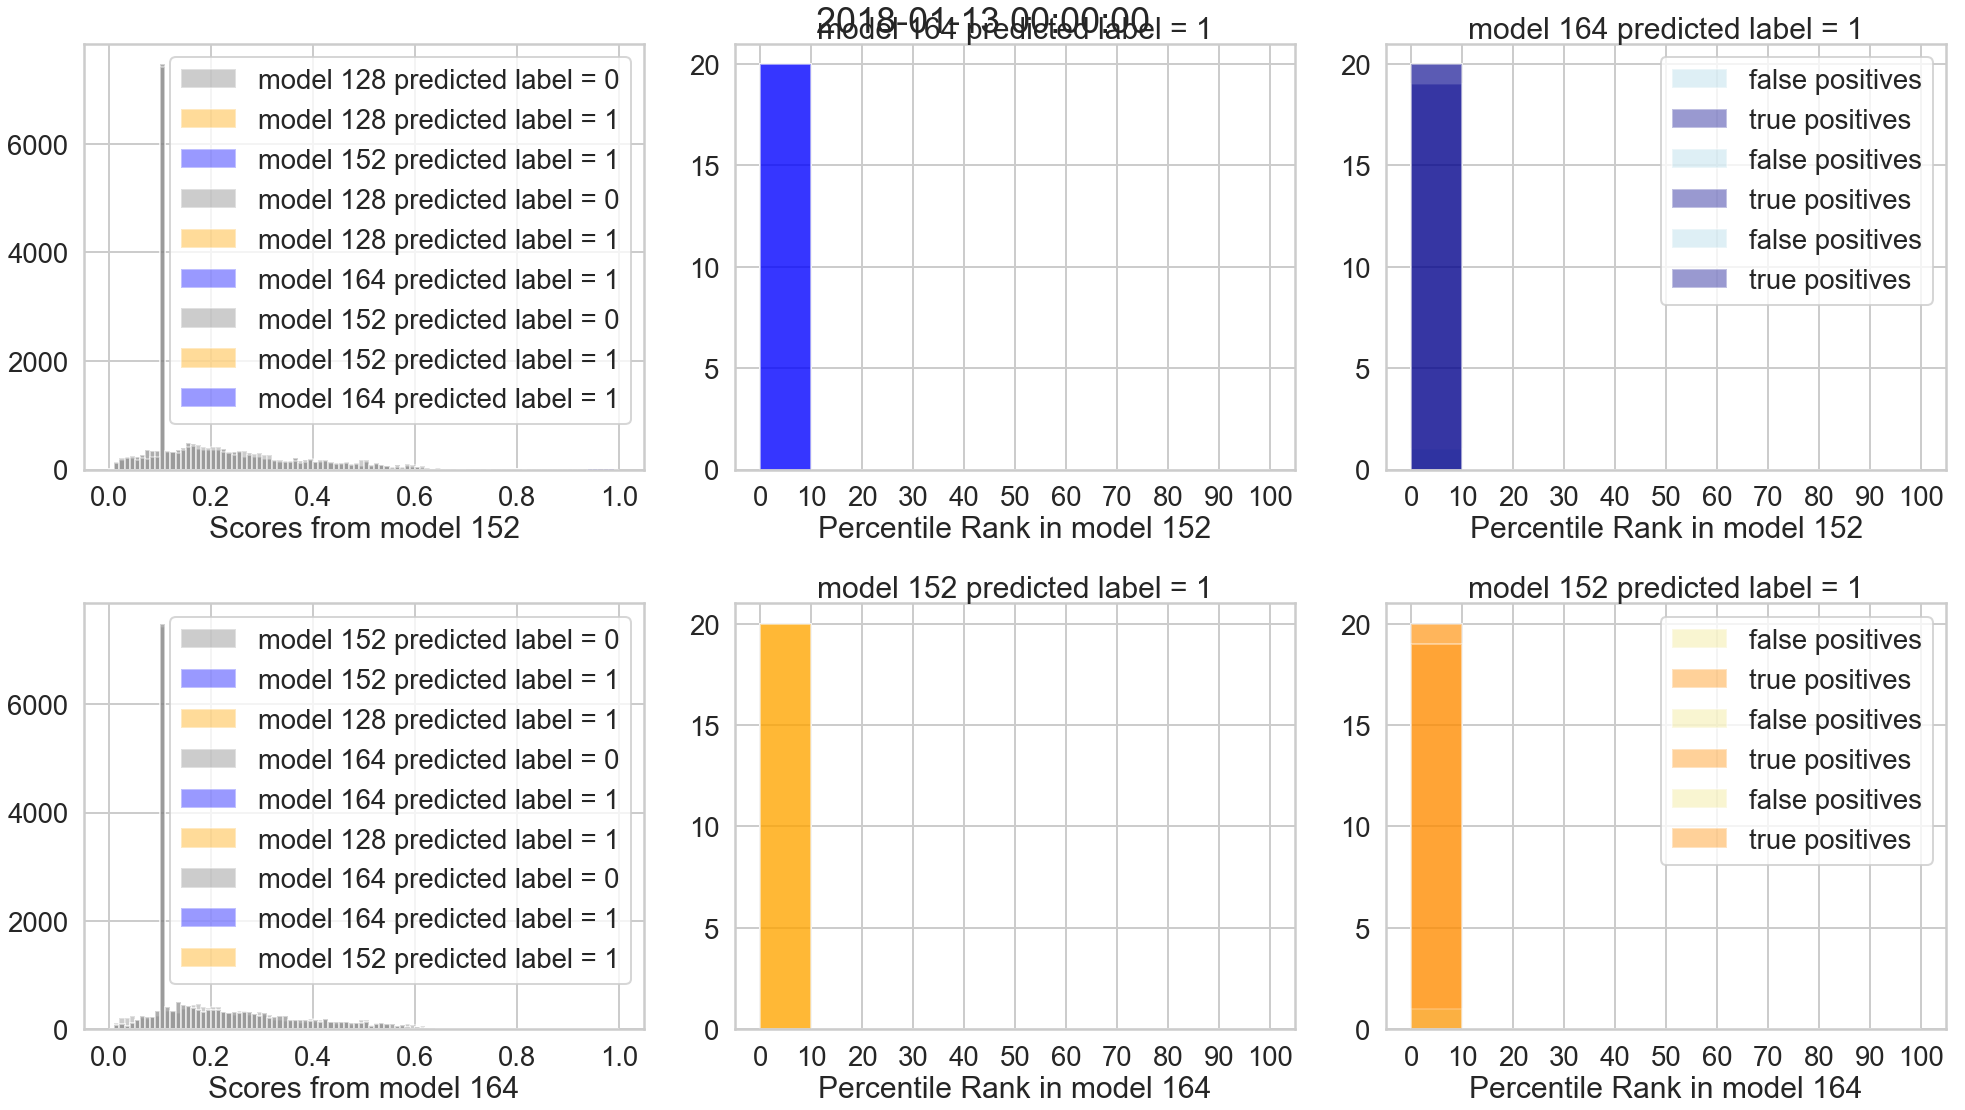

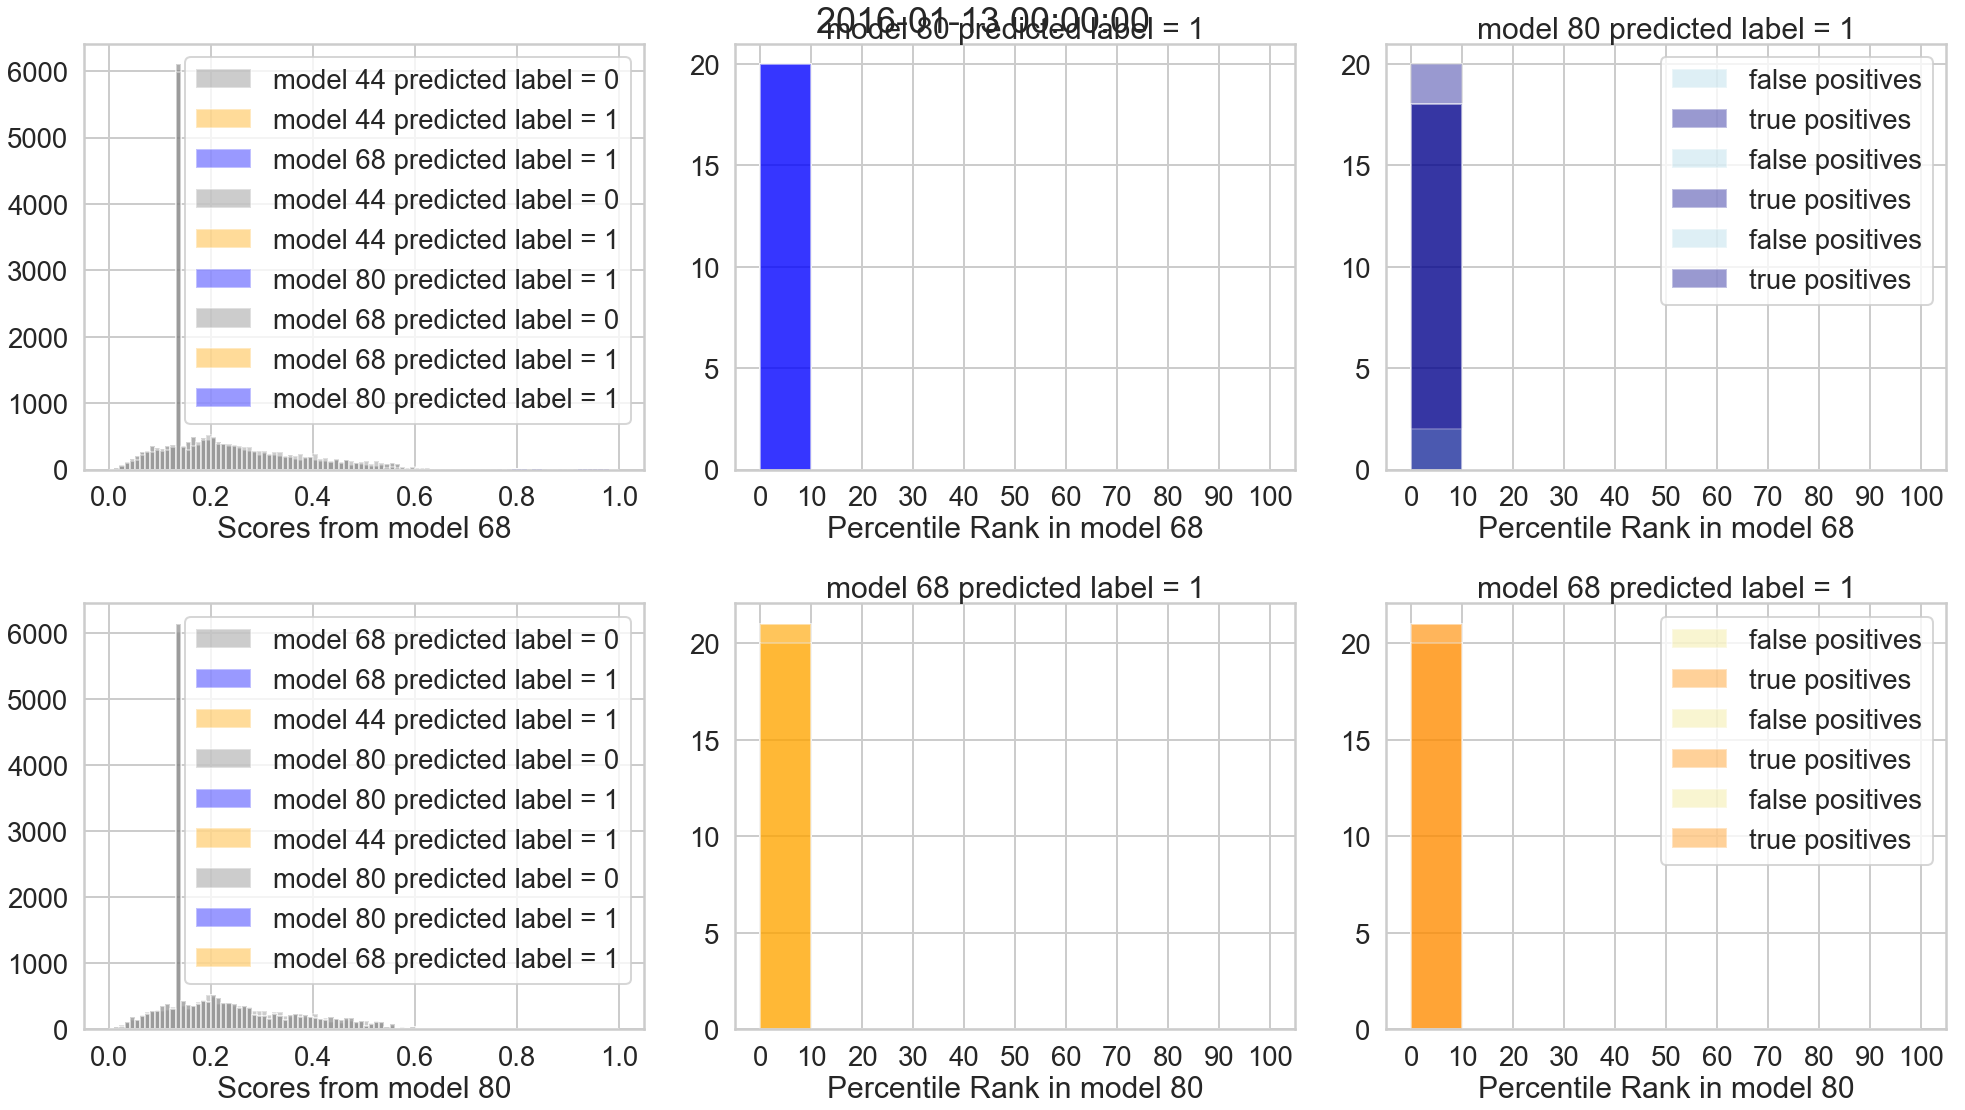

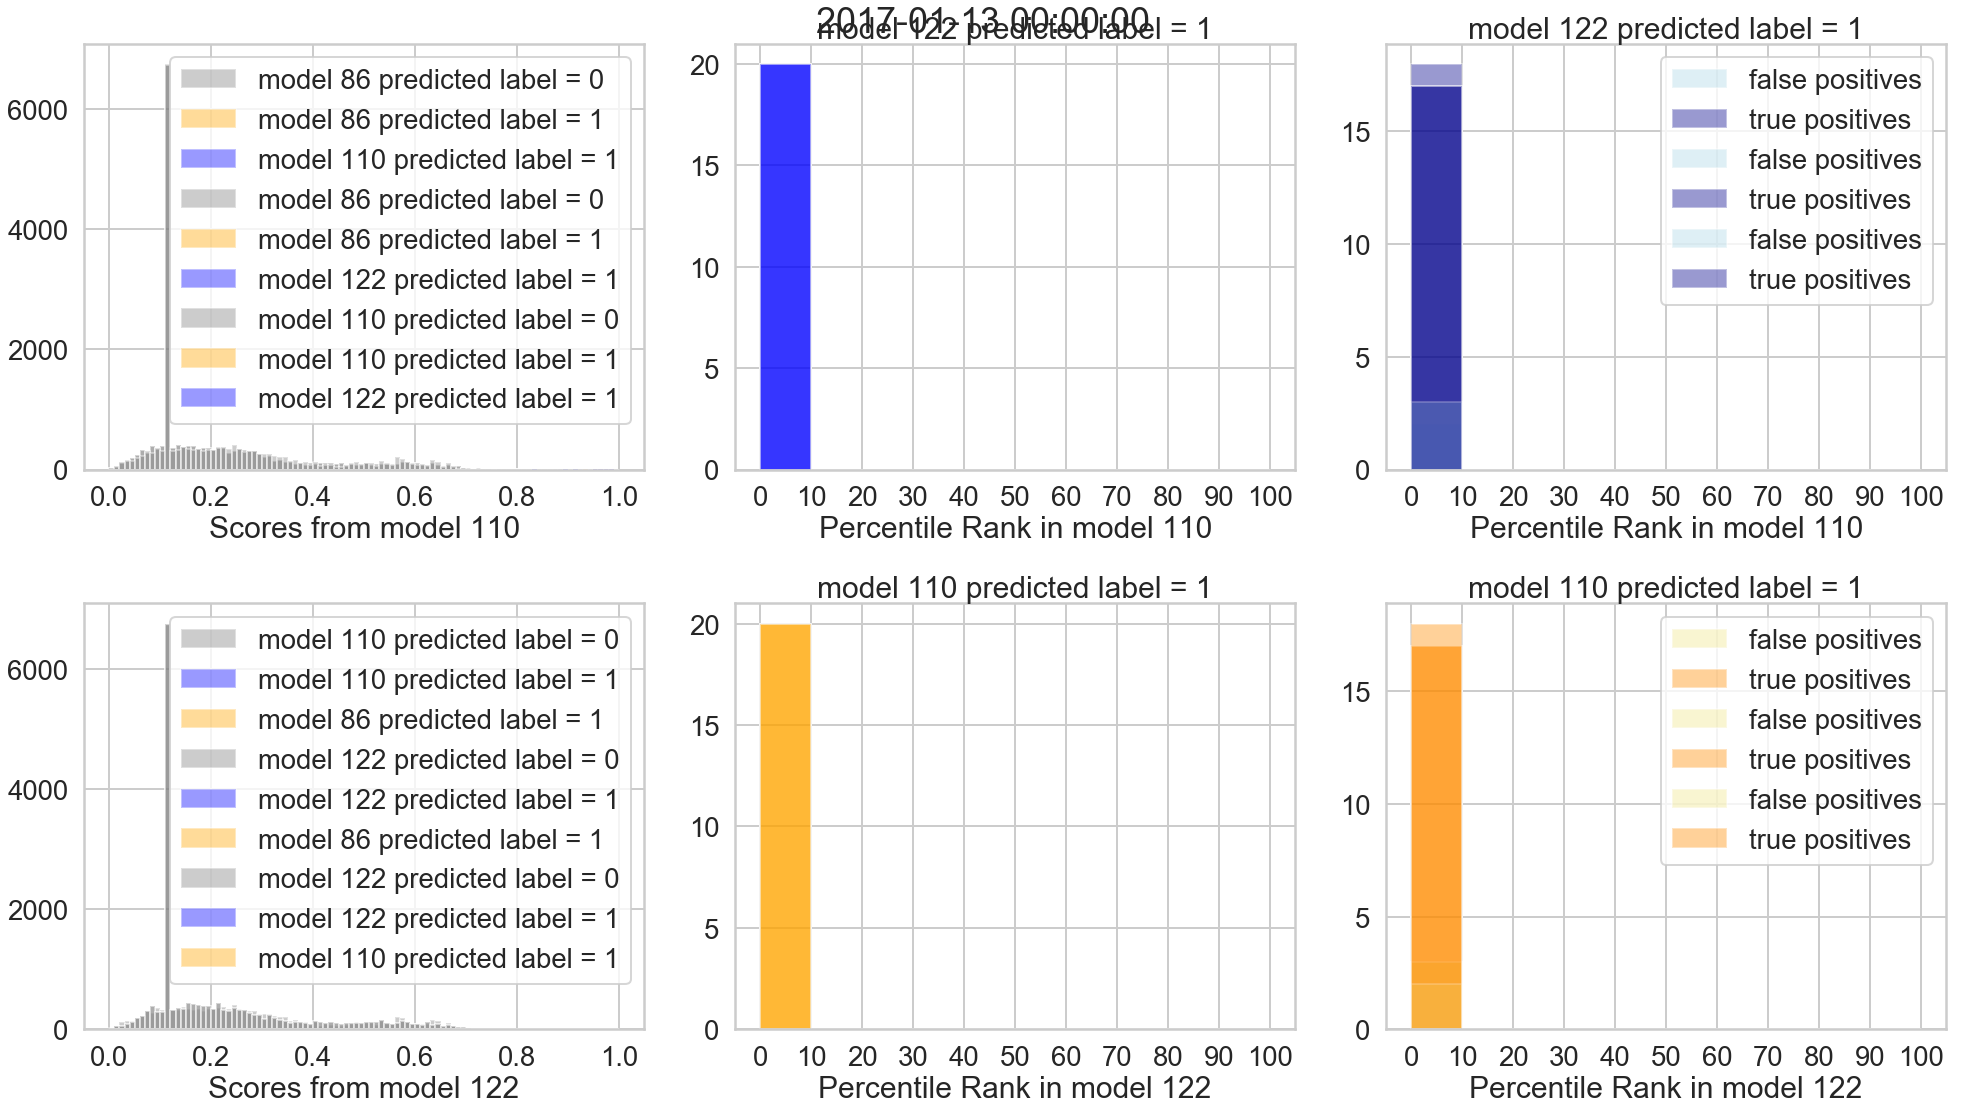

In [33]:
audited_models_class.plot_preds_comparison(param_type='rank_abs',
                                           param=20)

In [11]:
a = l_t[1].preds_matrix(path=params.project_path)

In [14]:
a

,entity_id,as_of_date,results_entity_id_1y_result__NULL_avg,results_entity_id_1y_result__NULL_sum,results_entity_id_1y_result_fail_avg,results_entity_id_1y_result_fail_sum,results_entity_id_1y_result_pass w/ conditions_avg,results_entity_id_1y_result_pass w/ conditions_sum,results_entity_id_1y_result_pass_avg,results_entity_id_1y_result_pass_sum,...,risks_zip_code_6month_risk_low_sum,risks_zip_code_6month_risk_medium_avg,risks_zip_code_6month_risk_medium_sum,inspected,model_id,score,label_value,rank_abs,rank_pct,test_label_timespan
0,1,2016-01-13,1.0,1.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,68,0.134294,0,10509,56.009808,30 days
1,2,2016-01-13,1.0,1.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,68,0.134294,0,10509,56.009808,30 days
2,5,2016-01-13,1.0,1.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,10.0,0.173333,39.0,0.0,68,0.294138,0,4543,24.209797,30 days
3,6,2016-01-13,1.0,1.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,68,0.134294,0,10509,56.009808,30 days
4,7,2016-01-13,1.0,1.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,68,0.134294,0,10509,56.009808,30 days
5,8,2016-01-13,1.0,1.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,0.0,0.000000,0.0,0.0,68,0.134294,0,10509,56.009808,30 days
6,9,2016-01-13,0.0,0.0,0.000000,0.0,0.000000,0.0,1.000000,1.0,...,12.0,0.181818,34.0,0.0,68,0.256215,0,5751,30.648686,30 days
7,10,2016-01-13,1.0,1.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,...,4.0,0.492063,31.0,0.0,68,0.237379,0,6428,34.257236,30 days
8,13,2016-01-13,0.0,0.0,0.000000,0.0,0.000000,0.0,1.000000,1.0,...,25.0,0.282421,98.0,0.0,68,0.265126,0,5408,28.820425,30 days
9,14,2016-01-13,0.0,0.0,0.000000,0.0,0.000000,0.0,1.000000,1.0,...,9.0,0.508772,58.0,0.0,68,0.295064,0,4495,23.953947,30 days
